# Train a shallow SNN on the Randman Dataset

In [4]:
import sys

sys.path.append("../")
sys.path.append("../../")
import stork

import numpy as np
import torch

import matplotlib.pyplot as plt
import seaborn as sns

import stork.datasets
from stork.models import RecurrentSpikingModel
from stork.nodes import InputGroup, ReadoutGroup, LIFGroup
from stork.connections import Connection
from stork.generators import StandardGenerator
from stork.initializers import FluctuationDrivenCenteredNormalInitializer

## Generate Dataset

Specify the Dataset Parameters

In [5]:
dim_manifold = 1
nb_classes = 5
nb_inputs = 10
nb_time_steps = 50
step_frac = 0.5
nb_samples = 250
nb_spikes = 1
alpha = 1
randmanseed = 1
dt = 2e-3

duration = nb_time_steps * dt

In [6]:
data, labels = stork.datasets.make_tempo_randman(
    dim_manifold=dim_manifold,
    nb_classes=nb_classes,
    nb_units=nb_inputs,
    nb_steps=nb_time_steps,
    step_frac=step_frac,
    nb_samples=nb_samples,
    nb_spikes=nb_spikes,
    alpha=alpha,
    seed=randmanseed,
)

ds_kwargs = dict(nb_steps=nb_time_steps, nb_units=nb_inputs, time_scale=1.0)

# Split into train, test and validation set
datasets = [
    stork.datasets.RasDataset(ds, **ds_kwargs)
    for ds in stork.datasets.split_dataset(
        data, labels, splits=[0.8, 0.1, 0.1], shuffle=False
    )
]
ds_train, ds_valid, ds_test = datasets

In [9]:
ds_train[0][0].shape

torch.Size([50, 10])

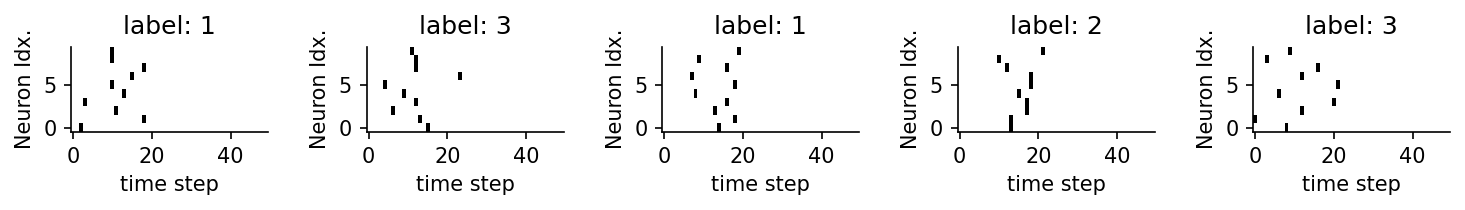

In [ ]:
fig, ax = plt.subplots(1, 5, figsize=(10, 1.5), dpi=150)
for i in range(5):
    ax[i].imshow(np.transpose(ds_train[i][0]), cmap="binary", aspect="auto")
    ax[i].invert_yaxis()
    ax[i].set_xlabel("time step")
    ax[i].set_ylabel("Neuron Idx.")
    ax[i].set_title("label: " + str(ds_train[i][1]))

plt.tight_layout()
sns.despine()

## Set up the model

In [ ]:
# Model Parameters
batch_size = 25
beta = 20
device = torch.device("cpu")
dtype = torch.float


nb_hidden_units = 128
tau_mem = 20e-3
tau_syn = 10e-3
tau_readout = duration

lr = 5e-3
nb_epochs = 50
print(duration)

0.1


In [ ]:
act_fn = stork.activations.SuperSpike
act_fn.beta = beta
neuron_group = LIFGroup

model = RecurrentSpikingModel(batch_size, nb_time_steps, nb_inputs, device, dtype)

Add neuron groups

In [ ]:
input_group = model.add_group(InputGroup(nb_inputs))
hidden_neurons = model.add_group(
    LIFGroup(nb_hidden_units, tau_mem=tau_mem, tau_syn=tau_syn, activation=act_fn)
)
readout_group = model.add_group(
    ReadoutGroup(nb_classes, tau_mem=tau_readout, tau_syn=tau_syn, initial_state=-1e-2)
)

Add synapses between the neuron groups

In [ ]:
con = model.add_connection(Connection(input_group, hidden_neurons, enable_delays=True,learn_delays=True))
con_ro = model.add_connection(Connection(hidden_neurons, readout_group, enable_delays=True, learn_delays=True))

Add regularizers

In [ ]:
# Define regularizer parameters (set regularizer strenght to 0, if you don't want to use them)
lowerBoundL2Strength = 100
lowerBoundL2Threshold = 1e-3
upperBoundL2Strength = 0.1
upperBoundL2Threshold = (
    4  # Regularizes spikecount: 4 spikes ~ 20 Hz in 200ms simulation time
)

# Define regularizer list
regs = []

regLB = stork.regularizers.LowerBoundL2(
    lowerBoundL2Strength, threshold=lowerBoundL2Threshold, dims=False
)
regs.append(regLB)
regUB = stork.regularizers.UpperBoundL2(
    upperBoundL2Strength, threshold=upperBoundL2Threshold, dims=1
)
regs.append(regUB)

# Add to neurons
hidden_neurons.regularizers.extend(regs)

# EXPERIMENTAL: Initialize delays

In [ ]:
saved_init_delays = []

for c in model.connections:
    init_delays = torch.rand(c.delays.shape) * duration / 2
    c.set_delays(init_delays)
    saved_init_delays.append(init_delays)

We initialize the network in the Flucutation-Driven regime, with a target membrane potential standard deviation $\sigma_U=1.0$

In [ ]:
sigma_u = 1.0
nu = nb_spikes / duration

initializer = FluctuationDrivenCenteredNormalInitializer(
    sigma_u=1.0, nu=nu, timestep=dt
)

con.init_parameters(initializer=initializer)
con_ro.init_parameters(initializer=initializer)

Add monitors for spikes and membrane potential

In [ ]:
model.add_monitor(stork.monitors.SpikeCountMonitor(model.groups[1]))
model.add_monitor(stork.monitors.StateMonitor(model.groups[1], "out"))

Choose loss function (We chose a maximum over time crossentropy loss, where the class is chosen according to the readout neuron that has the highest membrane potential over the simulation time)

In [ ]:
loss_stack = stork.loss_stacks.MaxOverTimeCrossEntropy()

We select the SMORMS3 optimizer

In [ ]:
opt = stork.optimizers.SMORMS3
generator = StandardGenerator(nb_workers=2)

In [ ]:
model.configure(
    input=input_group,
    output=readout_group,
    loss_stack=loss_stack,
    generator=generator,
    optimizer=opt,
    optimizer_kwargs=dict(lr=lr),
    time_step=dt,
)

Before we train the model, we monitor the spikes

In [ ]:
# Monitors spike counts before training
res = model.monitor(ds_test)
total_spikes = torch.sum(res[0]).item()

results = {}
res = model.monitor(ds_test)
total_spikes_per_layer = [torch.sum(res[i]).item() for i in range(1)]
results["avg_layer_freq_init"] = [
    nb / len(ds_test) / duration / nb_hidden_units for nb in total_spikes_per_layer
]

print(results)

{'avg_layer_freq_init': [9.116874999999999]}


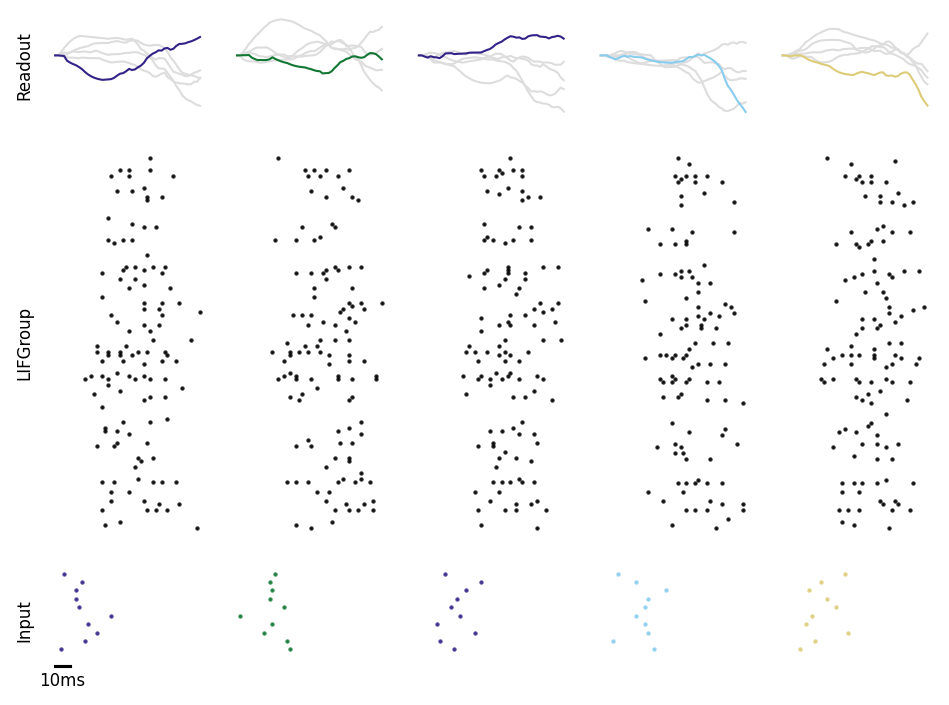

In [ ]:
plt.figure(dpi=150)
stork.plotting.plot_activity_snapshot(
    model, data=ds_test, point_alpha=0.8, show_predictions=False
)

## Training

takes around 13-20 minutes

In [ ]:
history = model.fit_validate(ds_train, ds_valid, nb_epochs=nb_epochs, verbose=True)

results["train_loss"] = history["loss"].tolist()
results["train_acc"] = history["acc"].tolist()
results["valid_loss"] = history["val_loss"].tolist()
results["valid_acc"] = history["val_acc"].tolist()

00  loss=1.61 reg_loss=5e-05 acc=0.244 -- val_loss=1.6 val_reg_loss=4.9e-05 val_acc=0.256 t_iter=8.58
01  loss=1.57 reg_loss=4.73e-05 acc=0.305 -- val_loss=1.58 val_reg_loss=4.63e-05 val_acc=0.272 t_iter=8.23
02  loss=1.53 reg_loss=4.5e-05 acc=0.36 -- val_loss=1.6 val_reg_loss=4.42e-05 val_acc=0.256 t_iter=7.77
03  loss=1.47 reg_loss=4.31e-05 acc=0.422 -- val_loss=1.57 val_reg_loss=4.24e-05 val_acc=0.288 t_iter=7.93
04  loss=1.41 reg_loss=4.16e-05 acc=0.478 -- val_loss=1.5 val_reg_loss=4.09e-05 val_acc=0.368 t_iter=8.46
05  loss=1.36 reg_loss=4e-05 acc=0.511 -- val_loss=1.48 val_reg_loss=3.96e-05 val_acc=0.352 t_iter=7.99
06  loss=1.31 reg_loss=3.88e-05 acc=0.545 -- val_loss=1.52 val_reg_loss=3.86e-05 val_acc=0.336 t_iter=7.91
07  loss=1.28 reg_loss=3.77e-05 acc=0.555 -- val_loss=1.49 val_reg_loss=3.75e-05 val_acc=0.344 t_iter=7.99
08  loss=1.24 reg_loss=3.67e-05 acc=0.577 -- val_loss=1.5 val_reg_loss=3.65e-05 val_acc=0.328 t_iter=7.76
09  loss=1.21 reg_loss=3.57e-05 acc=0.592 -- val_l

#### Monitor the model again after training

In [ ]:
res = model.monitor(ds_test)
total_spikes_per_layer = [torch.sum(res[i]).item() for i in range(1)]
results["avg_layer_freq"] = [
    nb / len(ds_test) / duration / nb_hidden_units for nb in total_spikes_per_layer
]

## Test

In [ ]:
scores = model.evaluate(ds_test).tolist()
results["test_loss"], _, results["test_acc"] = scores

Test loss:  1.287218189239502
Test acc.:  49.6 %


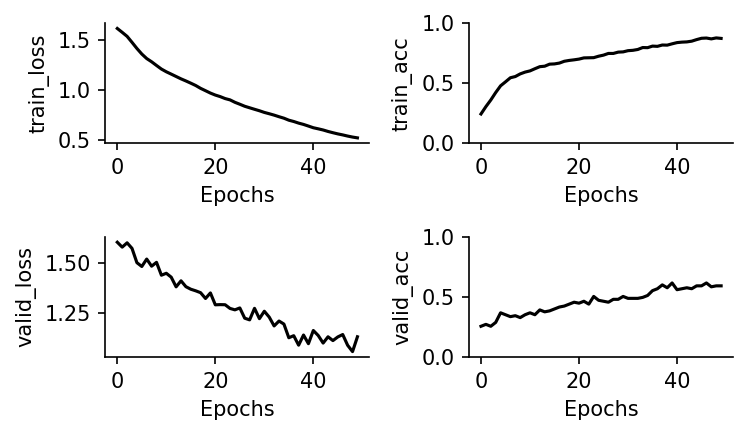

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(5, 3), dpi=150)

for i, n in enumerate(["train_loss", "train_acc", "valid_loss", "valid_acc"]):
    if i < 2:
        a = ax[0][i]
    else:
        a = ax[1][i - 2]

    a.plot(results[n], color="black")
    a.set_xlabel("Epochs")
    a.set_ylabel(n)

ax[0, 1].set_ylim(0, 1)
ax[1, 1].set_ylim(0, 1)

sns.despine()
plt.tight_layout()

print("Test loss: ", results["test_loss"])
print("Test acc.: ", round(results["test_acc"] * 100, 2), "%")

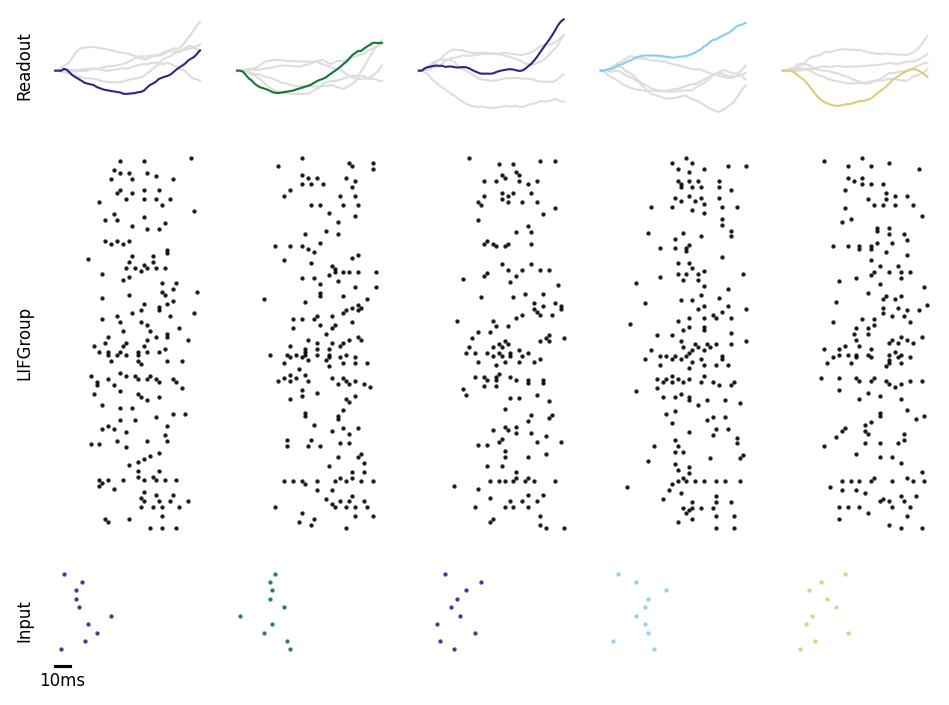

In [ ]:
plt.figure(dpi=150)
stork.plotting.plot_activity_snapshot(
    model, data=ds_test, point_alpha=0.8, show_predictions=False, nb_samples=5
)

In [ ]:
model.connections[0].delays


Parameter containing:
tensor([[0.0178, 0.0199, 0.0401,  ..., 0.0180, 0.0386, 0.0004],
        [0.0041, 0.0452, 0.0447,  ..., 0.0044, 0.0354, 0.0047],
        [0.0371, 0.0371, 0.0156,  ..., 0.0498, 0.0459, 0.0108],
        ...,
        [0.0024, 0.0177, 0.0306,  ..., 0.0146, 0.0438, 0.0057],
        [0.0184, 0.0080, 0.0057,  ..., 0.0074, 0.0181, 0.0040],
        [0.0139, 0.0482, 0.0319,  ..., 0.0177, 0.0268, 0.0041]],
       requires_grad=True)

In [ ]:
print(model.connections[0].delays.grad_fn)
print(model.connections[0].op.weight.grad_fn)

# print a list of all the parameters in the model and their names
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.data.shape)

None
None
con1.delays torch.Size([128, 10])
con1.op.weight torch.Size([128, 10])
con2.delays torch.Size([5, 128])
con2.op.weight torch.Size([5, 128])


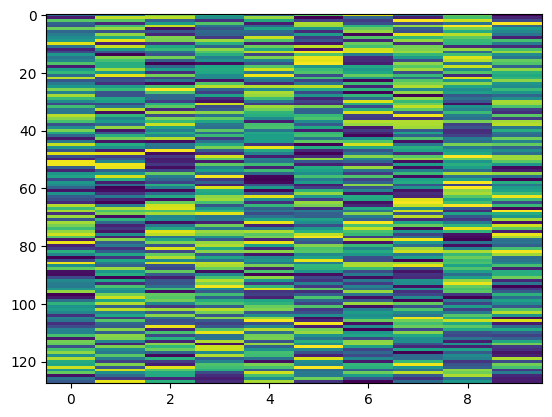

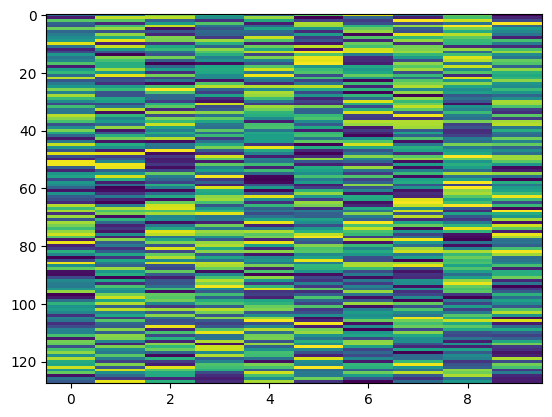

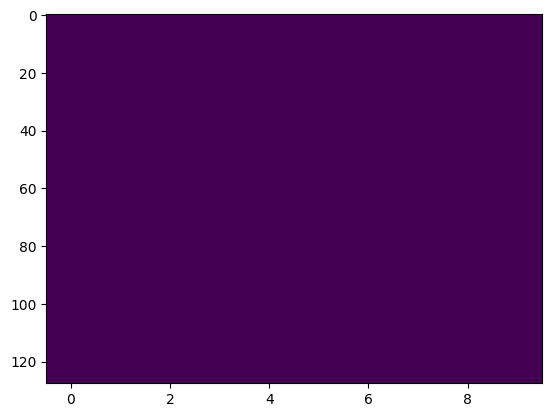

In [ ]:
plt.imshow(saved_init_delays[0], aspect="auto", interpolation="nearest")
plt.show()
plt.imshow(model.connections[0].delays.detach(), aspect="auto", interpolation="nearest")
plt.show()
plt.imshow(model.connections[0].delays.detach()-saved_init_delays[0], aspect="auto", interpolation="nearest")


In [ ]:
model.connections[0].op.weight.grad

tensor([[-5.6500e-05, -2.1223e-04,  1.3515e-05,  ..., -2.4928e-04,
         -1.6689e-05, -1.4461e-04],
        [-7.0506e-04,  1.6623e-04, -1.4858e-04,  ..., -2.2680e-04,
          4.3875e-04, -7.0295e-05],
        [-9.8457e-04, -3.2254e-05, -2.3044e-03,  ..., -5.3048e-04,
          1.2179e-05, -4.2923e-03],
        ...,
        [-2.8966e-03,  5.1060e-04, -9.0431e-04,  ...,  3.7322e-04,
          8.7809e-06,  4.6792e-04],
        [ 5.7502e-03,  6.0643e-03,  4.7646e-03,  ...,  4.4705e-03,
          3.4773e-03,  6.4458e-03],
        [-1.8291e-03, -5.3255e-04, -4.1032e-06,  ..., -1.0016e-03,
         -1.8020e-04, -2.6394e-04]])